# Linear transformations with landmarks

In this module we'll work with linear and affine transformations.

We will show how to apply them to labelled point sets, called landmarks.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import summerschool as ss
import os # for os.path.join to work with windows and mac/linux

## Let's start by loading data

We'll start by loading a set of landmarks and a corresponding triangulated surface for one example

Landmarks are stored in text files that list how many points, the dimension of the points, and then the location of each point.  The number and dimension are integers, and the location of points are real numbers (floats), and in this example they have units of mm.

Note that this hippcampus landmark data was created by identifying the head and tail of the hippocampus, then identifying the lateral, medial, superior, and inferior margins on 9 slices between the head and tail.  This gives 38 points total.

Surfaces are also stored in a text file, as triangulated meshes.  There are many different file formats, but the basic idea is first to list all the vertices of the mesh (real numbers), then we list how they are grouped into triangles (sets of three integers corresponding to the index of each vertex).

In [2]:
# get a landmarks
fname = os.path.join('hipAmygLandmarks', 'hippocampus_01_landmarks.txt')
X = ss.load_landmarks(fname)
print('Loaded landmarks file')
print('size of landmarks data "X" is {}'.format(X.shape))
print('The 3 means 3 dimensional data, the next number is the total number of landmarks')
# landmarks are saved in an order 2 numpy array, with 3 rows and N columns (here 38)
# a surface
fname = os.path.join('hipAmygLandmarks', 'hippocampus_01_surface.byu')
V,F = ss.load_surface(fname)
# vertices V are in the same form as F
print('size of vertices V is {}'.format(V.shape))
# F triples of indices corresponding to triangles, for input into the trisurf function
# write about vertices

# note for daniel, use a dataset that is not centered

Loaded landmarks file
size of landmarks data "X" is (3, 38)
The 3 means 3 dimensional data, the next number is the total number of landmarks
size of vertices V is (3, 625)


<IPython.core.display.Javascript object>


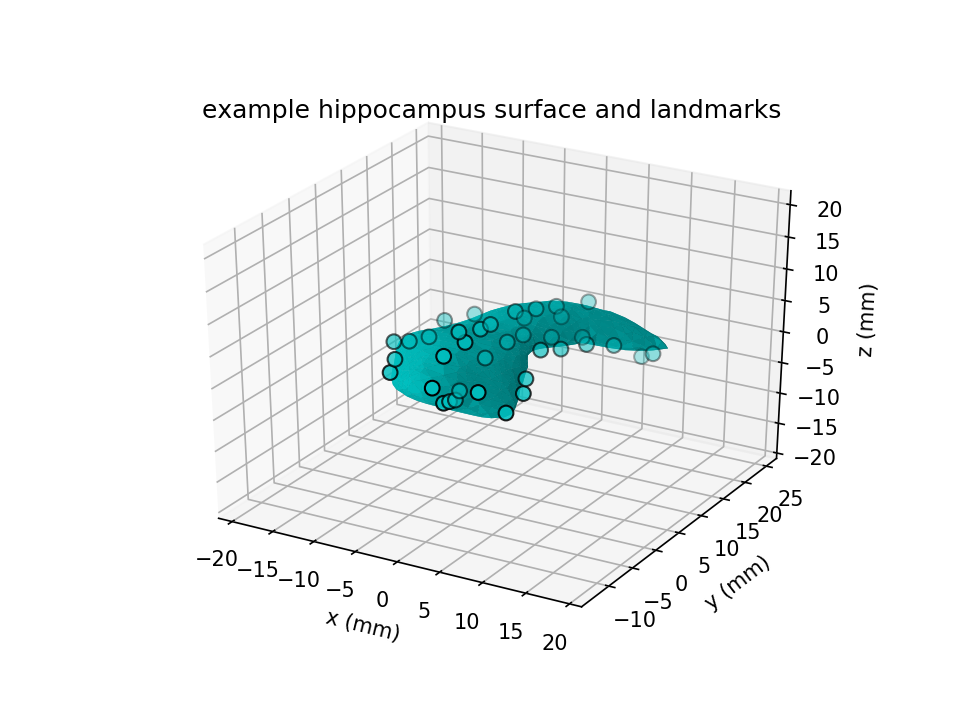

Text(0.5,0.92,'example hippocampus surface and landmarks')

In [3]:
# Make a nice figure to show them
f = plt.figure()
# 3D axes are constructed in matplotlib by importing:
# from mpl_toolkits.mplot3d import Axes3D
# and then setting the projection='3d' property when creating a subplot
ax = f.add_subplot(111, projection='3d')
hp = ax.scatter(
    X[0,:], X[1,:], X[2,:], # the x,y,z components of all the vertices
    s=50, # size is 50 pixels
    c='c', # color is cyan
    edgecolor='k' # draw a black circle around
) 
hs = ax.plot_trisurf(
    V[0,:], V[1,:], V[2,:], # the x,y,z components of all the vertices
    triangles=F, # how are the vertices connected up into triangular faces
    edgecolor='none', # don't draw edges, this will look too busy
    color='c' # color is cyan
)
# 3D axes do not support a nice command for equal aspect ratio, 
# axis_equal is implemented in the summer shool module
ss.axis_equal(ax)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.set_title('example hippocampus surface and landmarks')


## Plot lots of surfaces
Now that we've seen how to do it, let's plot two of them.  This will allow us to start getting a sense of anatomical variability.

<IPython.core.display.Javascript object>


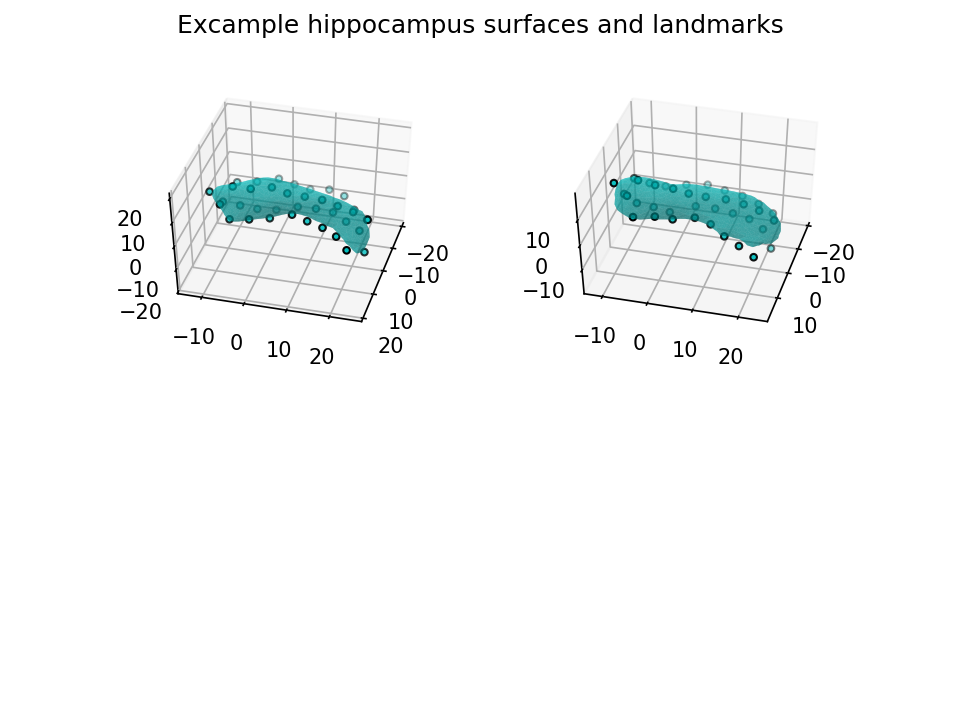

Text(0.5,0.98,'Excample hippocampus surfaces and landmarks')

In [4]:
f = plt.figure()
nshow = 2
nrow = np.ceil(np.sqrt(nshow))
ncol = nrow
Vall = []
Fall = []
Xall = []
for i in range(nshow):
    fname = os.path.join('hipAmygLandmarks', 'hippocampus_{:02d}_surface.byu'.format(i+1))
    V,F = ss.load_surface(fname)
    fname = os.path.join('hipAmygLandmarks', 'hippocampus_{:02d}_landmarks.txt'.format(i+1))
    X = ss.load_landmarks(fname)
    ax = f.add_subplot(nrow, ncol, i+1, projection='3d')
    color = 'c'
    hp = ax.scatter(X[0,:], X[1,:], X[2,:], s=10, c=color, edgecolor='k')
    hs = ax.plot_trisurf(V[0,:], V[1,:], V[2,:], triangles=F,
                        edgecolor='none', linewidth=0, color=color, alpha=0.5)
    ax.view_init(45, 15)
    ss.axis_equal(ax)
    
    # save  for later use
    Vall.append(V)
    Fall.append(F)
    Xall.append(X)
    
f.suptitle('Excample hippocampus surfaces and landmarks')

## Applying transformations
Here we will apply some randomly generated transformations to our hippocampus to see the effect of different types of transformations, and also how to apply matrix transformations in numpy.  Note that to work with translations and linear transformations simultaneously through matrix multiplication, we use homogeneous coordinates.  Here vectors are augmented as 
\begin{align*}
x = \begin{pmatrix}
x_1\\x_2\\x_3
\end{pmatrix}
\mapsto
\tilde x = 
\begin{pmatrix}
x_1\\x_2\\x_3\\1
\end{pmatrix}
\end{align*}

And linear transformations $A$ and translations $b$ are combined as
\begin{align*}
A = \begin{pmatrix}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}\\
a_{31} & a_{32} & a_{33}\\
\end{pmatrix}
,
b = \begin{pmatrix}
b_1\\b_2\\b_3
\end{pmatrix}
\mapsto
\tilde A
\begin{pmatrix}
a_{11} & a_{12} & a_{13} & b_1\\
a_{21} & a_{22} & a_{23} & b_2\\
a_{31} & a_{32} & a_{33} & b_3\\
0 & 0 & 0 & 1
\end{pmatrix}
\end{align*}

Note that the first three components of $\tilde A \tilde x$ are equal to those of $Ax+b$, and the fourth component is always equal to 1.

## Vector fields
We can also characterize a transformation by specifying the displacement at every point $x$.  We call this a vector field.  For matrix transformations, the displacement at every point is given simply by
\begin{align*}
v(x) &= Ax - x\\
&= (A - Id)x
\end{align*}

We illustrate some examples below in 2D and in 3D.  2D examples are particularly fruitful because we can visualize them effectively.

<IPython.core.display.Javascript object>


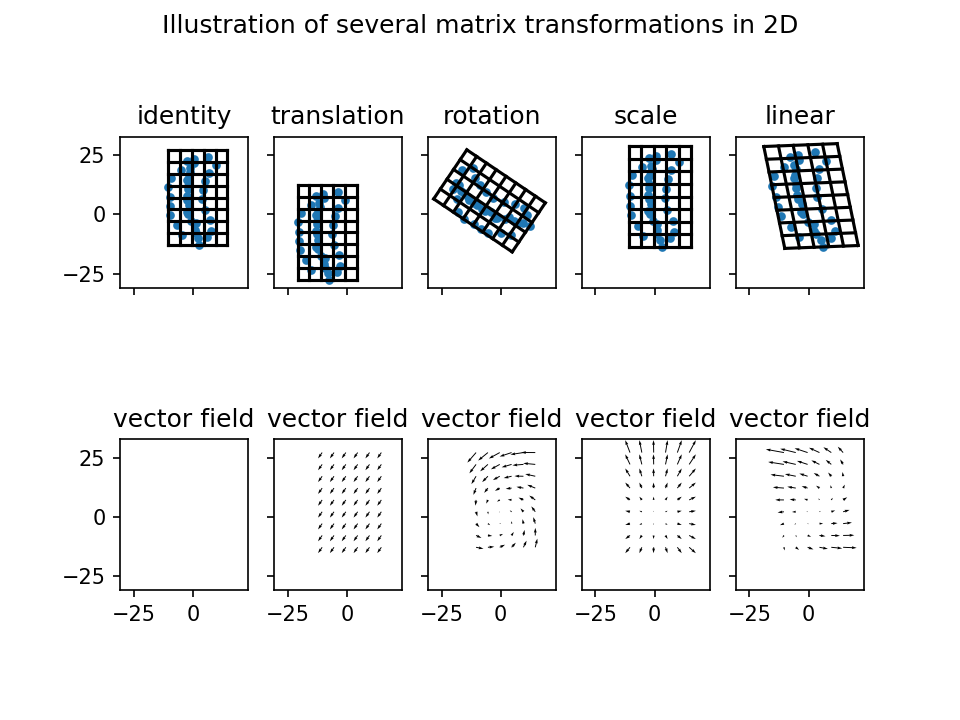

Text(0.5,0.98,'Illustration of several matrix transformations in 2D')

In [5]:
# first we'll visualize in 2D
# important to visualize
# Choose a subject to visualize
index = 0
X = Xall[index][:2,:]
Xh = np.concatenate([X,np.ones((1,X.shape[1]))], axis=0)

# make a figure
nplots = 5
f,ax = plt.subplots(2, nplots, sharex=True, sharey=True)
for i in range(nplots):
    ax_ = ax[:,i]
    # let's plot a grid
    dx = 5.0
    x0 = np.arange(np.min(X[0,:]), np.max(X[0,:])+dx,dx)
    x1 = np.arange(np.min(X[1,:]), np.max(X[1,:])+dx,dx)
    X0,X1 = np.meshgrid(x0, x1, indexing='ij')

    # choose a transformation
    if i == 0:
        A = np.eye(3)
        titlestring = 'identity'
    elif i == 1:
        T = np.random.randn(2)*10.0 # this number will have to be changed for mouse
        A = np.array([[1,0,T[0]],[0,1,T[1]],[0,0,1]])
        titlestring = 'translation'
    elif i == 2:
        theta = np.random.rand()*2.0*np.pi/6.0
        A = np.eye(3)
        A[:2,:2]= [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
        titlestring = 'rotation'
    elif i==3:
        s = np.random.randn()*0.1 + 1.0
        A = np.eye(3)
        A[:2,:2] = np.eye(2)*s
        titlestring = 'scale'
    elif i == 4:
        A = np.eye(3)
        A[:2,:2] += np.random.randn(2,2)*0.2
        titlestring = 'linear'
    AX0 = A[0,0]*X0 + A[0,1]*X1 + A[0,2]
    AX1 = A[1,0]*X0 + A[1,1]*X1 + A[1,2]
    ss.plot_grid(AX0, AX1, ax=ax_[0])
    AX = A.dot(Xh)
    ax_[0].scatter(AX[0,:], AX[1,:], s=10)
    ax_[0].set_aspect('equal')
    ax_[0].set_title(titlestring)

    # let's show the vectorfield
    ax_[1].quiver(X0, X1, AX0-X0, AX1-X1)
    ax_[1].set_aspect('equal')
    ax_[1].set_title('vector field')
f.suptitle('Illustration of several matrix transformations in 2D')

## Now lets visualize in 3D

We'll work with the surface vertices here.  Surface faces to not need to be transformed.

<IPython.core.display.Javascript object>


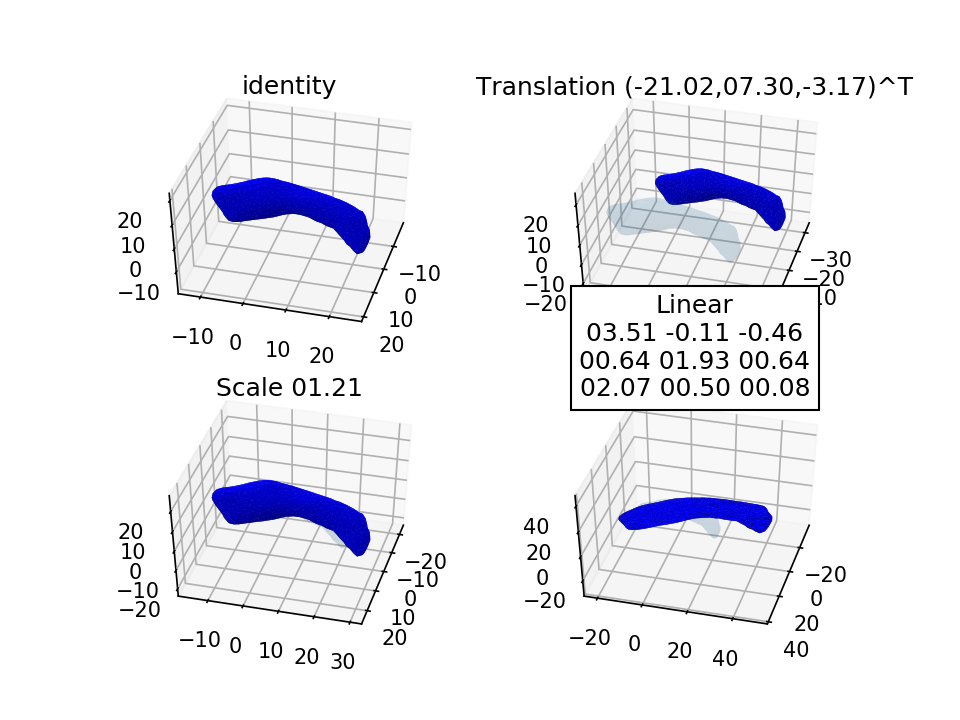

Text(0.5,0.92,'Linear\n03.51 -0.11 -0.46\n00.64 01.93 00.64\n02.07 00.50 00.08')

In [6]:
# Choose a subject to visualize
index = 0
F = Fall[index]
V = Vall[index]
X = Xall[index]

# Create homogeneous coordinates by appending with 1s
Vh = np.concatenate([V,np.ones((1,V.shape[1]))])
f = plt.figure()

# first identity
ax = f.add_subplot(221, projection='3d')
# First I'll show the original surface as a pale transparent blue
ax.plot_trisurf(V[0,:], V[1,:], V[2,:], triangles=F, alpha=0.1)
ax.view_init(45, 15)
# homogeneous transformation matrix is 4x4
A = np.eye(4)
# matrix multiplication is done in numpy using "dot"
AVh = A.dot(Vh)
ax.plot_trisurf(AVh[0,:], AVh[1,:], AVh[2,:], triangles=F, color='b')
ss.axis_equal(ax)
ax.set_title('identity')

# now translation
ax = f.add_subplot(222, projection='3d')
ax.plot_trisurf(V[0,:], V[1,:], V[2,:], triangles=F, alpha=0.1)
ax.view_init(45, 15)
# homogeneous transformation matrix
A = np.eye(4)
A[:3,-1] += np.random.randn(3)*10.0
AVh = A.dot(Vh)
ax.plot_trisurf(AVh[0,:], AVh[1,:], AVh[2,:], triangles=F, color='b')
ss.axis_equal(ax)
ax.set_title('Translation ({:-05.2f},{:-05.2f},{:-05.2f})^T'.format(*list(A[:3,-1])))


# now scale
ax = f.add_subplot(223, projection='3d')
ax.plot_trisurf(V[0,:], V[1,:], V[2,:], triangles=F, alpha=0.1)
ax.view_init(45, 15)
A = np.eye(4)*(1.0 + np.random.randn())
AVh = A.dot(Vh)
ax.plot_trisurf(AVh[0,:], AVh[1,:], AVh[2,:], triangles=F, color='b')
ss.axis_equal(ax)
ax.set_title('Scale {:-05.2f}'.format(A[0,0]))


# now linear
ax = f.add_subplot(224, projection='3d')
ax.plot_trisurf(V[0,:], V[1,:], V[2,:], triangles=F, alpha=0.1)
ax.view_init(45,15)
A = np.eye(4)
A[:3,:3] += np.random.randn(3,3)*1.5
AVh = A.dot(Vh)
ax.plot_trisurf(AVh[0,:], AVh[1,:], AVh[2,:], triangles=F, color='b')
ss.axis_equal(ax)
ax.set_title('''Linear
{:-05.2f} {:-05.2f} {:-05.2f}
{:-05.2f} {:-05.2f} {:-05.2f}
{:-05.2f} {:-05.2f} {:-05.2f}'''.format(A[0,0], A[0,1], A[0,2],
                                        A[1,0],A[1,1],A[1,2],
                                        A[2,0],A[2,1],A[2,2]),
                                        bbox={'fc':'w','ec':'k'})


## Estimating transformations

Generally given a set of labeled points $X$ and $Y$ we will want to estimate an optimal transformation that brings $AX$ close to $Y$.  This is typically done by minimizing sum of square error.  


### Translations
For example for translation $T$ we can define a cost function $E$ as
\begin{align}
E = \sum_{i = 1}^N \frac12|(X_i + T) - Y_i|^2
\end{align}
where $|\cdot|^2$ denotes the norm squared of each point.

We'd like to minimize this over translations.  Let's take the derivative with respect to $T$ and set it to zero.

\begin{align}
\nabla E &= \sum_{i = 1}^N 2(X_i + T - Y_i)
\end{align}
Setting to zero and rearranging gives
\begin{align}
T = \frac{1}{N}\sum_{i = 1}^N Y_i - X_i
\end{align}
In other words, the optimal translation is to subtract the mean of $X$ and add the mean of $Y$.



In [7]:
# choose some data to work with
X = Xall[0]
Y = Xall[1]
V0 = Vall[0]
V1 = Vall[1]
F0 = Fall[0]
F1 = Fall[1]

<IPython.core.display.Javascript object>


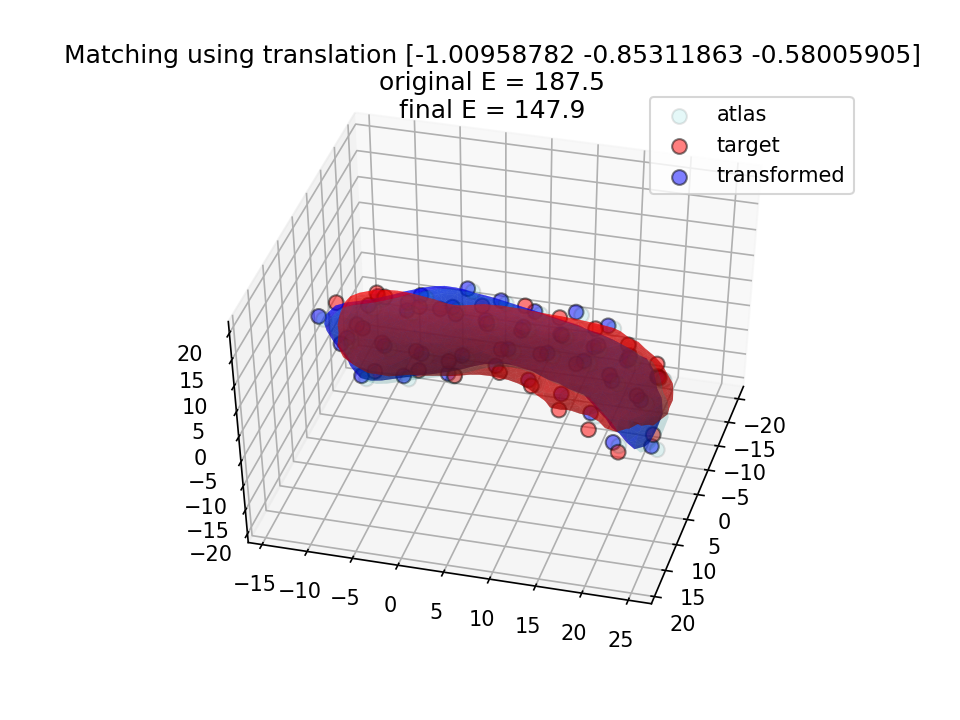

In [8]:
# Example: match X to Y using translation
T = np.mean(Y, axis=1) - np.mean(X, axis=1)
AX = X + T[:,None]
AV0 = V0 + T[:,None]
Ebefore = np.sum((X-Y)**2*0.5)
Eafter = np.sum((AX-Y)**2*0.5)
                 

f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.plot_trisurf(V0[0,:], V0[1,:], V0[2,:], triangles=F0, alpha=0.1, color='c')
h0 = ax.scatter(X[0,:], X[1,:], X[2,:], s=50, c='c', edgecolor='k', alpha=0.1)
ax.plot_trisurf(V1[0,:], V1[1,:], V1[2,:], triangles=F1, alpha=0.5, color='r')
hA0 = ax.scatter(Y[0,:], Y[1,:], Y[2,:], s=50, c='r', edgecolor='k', alpha=0.5)
ax.plot_trisurf(AV0[0,:], AV0[1,:], AV0[2,:],triangles=F0,alpha=0.5,color='b')
h1 = ax.scatter(AX[0,:], AX[1,:], AX[2,:],s=50,c='b',edgecolor='k',alpha=0.5)
ax.legend([h0,hA0,h1], ['atlas','target','transformed'])

ax.view_init(45, 15)
ss.axis_equal(ax)
ax.set_title('''Matching using translation {}
original E = {:4.1f}
final E = {:4.1f}'''.format(T, Ebefore, Eafter))

# save the cost to plot later
Eall = [Ebefore,Eafter]
Enames = ['Before', 'Translation']

### Scaling
Define a cost function $E$ as
\begin{align}
E(s) = \sum_{i = 1}^N \frac12 |s X_i - Y_i|^2
\end{align}

Take the gradient
\begin{align}
\nabla E(s) = \sum_{i = 1}^N 2(s X_i - Y_i) \cdot X_i
\end{align}

Set to zero and rearrange
\begin{align}
s = \frac{\frac1N\sum_{i = 1}^N Y_i \cdot X_i }{ \frac1N\sum_{i = 1}^N X_i \cdot X_i }
\end{align}

Note this pattern of "$XY$" over "$XX$".  In this case we have the variance of $X\cdot Y$ over the variance of $X \cdot X$.  We will see this again.

<IPython.core.display.Javascript object>


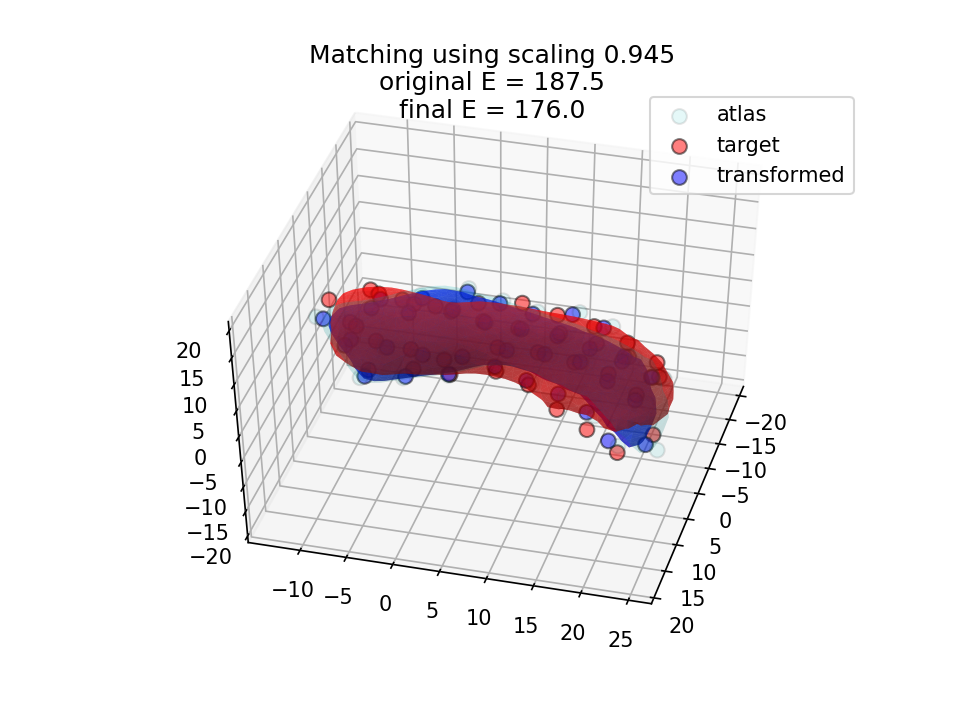

In [9]:
# Example: match X to Y using scaling
s = np.sum(X*Y)/np.sum(X*X)
AX = s*X
AV0 = s*V0
Ebefore = np.sum((X-Y)**2*0.5)
Eafter = np.sum((AX-Y)**2*0.5)

f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.plot_trisurf(V0[0,:], V0[1,:], V0[2,:], triangles=F0, alpha=0.1, color='c')
h0 = ax.scatter(X[0,:], X[1,:], X[2,:], s=50, c='c', edgecolor='k', alpha=0.1)
ax.plot_trisurf(V1[0,:], V1[1,:], V1[2,:], triangles=F1, alpha=0.5, color='r')
hA0 = ax.scatter(Y[0,:], Y[1,:], Y[2,:], s=50, c='r', edgecolor='k', alpha=0.5)
ax.plot_trisurf(AV0[0,:], AV0[1,:], AV0[2,:], triangles=F0, alpha=0.5, color='b')
h1 = ax.scatter(AX[0,:], AX[1,:], AX[2,:], s=50, c='b', edgecolor='k', alpha=0.5)
ax.legend([h0,hA0,h1], ['atlas','target','transformed'])
ax.view_init(45, 15)
ss.axis_equal(ax)
ax.set_title('''Matching using scaling {:5.3f}
original E = {:4.1f}
final E = {:4.1f}'''.format(s, Ebefore, Eafter))

# save the cost
Eall.append(Eafter)
Enames.append('Scale')

### Linear or affine
Define a cost function $E$ as
\begin{align}
E = \sum_{i = 1}^N \frac12 |A X_i - Y_i|^2
\end{align}
If $A$ and $X,Y$ are in homogeneous coordinates, then this corresponds to an affine transformation.  Otherwise a linear transformation.

We'd like to take the derivative and set to zero.  You may not know how to do this for a matrix.  Let's use a standard approach.  We'll take the directional derivative in the direction of $\delta A$, which is a matrix of the same dimension as $A$, and make sure the solution is stationary for all directions.

First we'll rewrite the norm as a trace
\begin{align}
E &= \sum_{i = 1}^N \frac12 |A X_i - Y_i|^2\\
&= \sum_{i = 1}^N \frac12 (A X_i - Y_i)^T(A X_i - Y)\\
&= \sum_{i = 1}^N \frac12 \text{trace}[(A X_i - Y_i)(A X_i - Y)^T]\\
\end{align}

Now take directional derivative
\begin{align}
&\frac{d}{d\epsilon} E(A + \epsilon \delta A)\bigg|_{\epsilon = 0} \\
&=\frac{d}{d\epsilon} \sum_{i = 1}^N \frac12 \text{trace}[(A X_i + \epsilon \delta A X_i- Y_i)(A X_i + \epsilon \delta A X_i- Y)^T] \bigg|_{\epsilon = 0}\\
&= \sum_{i = 1}^N \frac12 \text{trace}[(AX_i - Y_i)(\delta A X_i)^T + (\delta A X_i)(A X_i - Y_i)^T] \\
&= \sum_{i = 1}^N \text{trace}[(AX_i - Y_i)(\delta A X_i)^T ] \\
&= \sum_{i = 1}^N \text{trace}[[(AX_i - Y_i) X_i^T] \delta A^T ] \\
\end{align}
We used the fact that the trace is invariant to the transpose.

Now if this quantity is to vanish for all directions $\delta A$, the left hand term must be always zero.  So this implies we must have
\begin{align}
\sum_{i = 1}^N (AX_i - Y_i) X_i^T = 0
\end{align}
Rearranging and solving for $A$ gives
\begin{align}
A = \left( \frac{1}{N}\sum_{i = 1}^N Y_i X_i^T \right)\left(\frac{1}{N}\sum_{i = 1}^N X_i X_i^T\right)^{-1}
\end{align}
Again we see that the result takes the form of an "XY" over "XX", or inverse covariance, times a cross covariance.  This is a typical result in linear signal estimation.

Estimated affine matrix
[[ 9.61372919e-01 -1.24715234e-01 -6.35649805e-02 -1.23065512e-01]
 [ 1.68033350e-01  9.68200432e-01  1.41374003e-01 -7.24965141e-01]
 [ 4.47225761e-02 -1.66657424e-01  9.20673591e-01  6.44918977e-01]
 [ 3.46944695e-18 -1.99493200e-17 -5.55111512e-17  1.00000000e+00]]


<IPython.core.display.Javascript object>


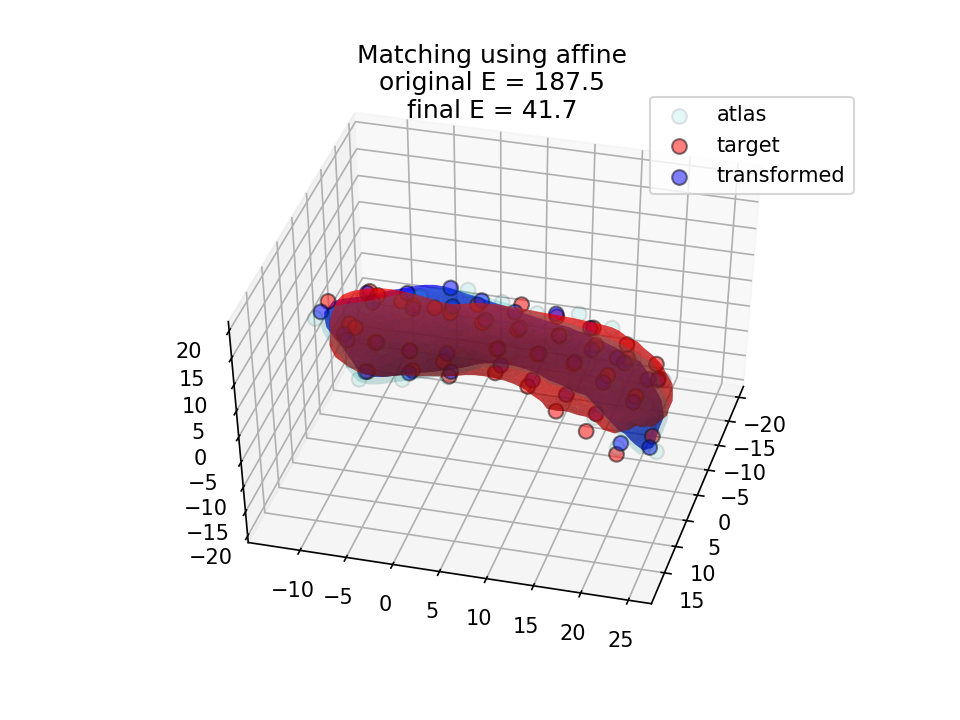

In [10]:
# Example: match X to Y using affine
# create homogeneous coords
Xh = np.concatenate([X,np.ones((1,X.shape[1]))], axis=0)
Yh = np.concatenate([Y,np.ones((1,X.shape[1]))], axis=0)
V0h = np.concatenate([V0,np.ones((1,V0.shape[1]))], axis=0)

# compute cross covariance, covariance, and estimate the matrix
xcov = Yh.dot(Xh.transpose())
cov = Xh.dot(Xh.transpose())
A = xcov.dot(np.linalg.inv(cov))
print('Estimated affine matrix')
print(A)

# transform the data
AXh = A.dot(Xh)
AX = AXh[:3,:]
AV0 = A[:3,:].dot(V0h)

# calculate the cost before and after
Ebefore = np.sum((X-Y)**2*0.5)
Eafter = np.sum((AXh-Yh)**2*0.5)

f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.plot_trisurf(V0[0,:], V0[1,:], V0[2,:], triangles=F0, alpha=0.1, color='c')
h0 = ax.scatter(X[0,:], X[1,:], X[2,:], s=50, c='c', edgecolor='k', alpha=0.1)
ax.plot_trisurf(V1[0,:], V1[1,:], V1[2,:], triangles=F1, alpha=0.5, color='r')
hA0 = ax.scatter(Y[0,:], Y[1,:], Y[2,:], s=50, c='r', edgecolor='k', alpha=0.5)
ax.plot_trisurf(AV0[0,:], AV0[1,:], AV0[2,:], triangles=F0, alpha=0.5, color='b')
h1 = ax.scatter(AX[0,:], AX[1,:], AX[2,:], s=50, c='b', edgecolor='k', alpha=0.5)
ax.legend([h0,hA0,h1], ['atlas','target','transformed'])
ax.view_init(45, 15)
ss.axis_equal(ax)
ax.set_title('''Matching using affine
original E = {:4.1f}
final E = {:4.1f}'''.format(Ebefore, Eafter))

# save the cost
Eall.append(Eafter)
Enames.append('Affine')

### Bonus: Rotations
Because rotation matrices do not lie in a vector space (if you add and subtract them you will not generally get another rotation), we have to use different methods for solving this problem.  Feel free to skip this derivation, but you may want to remember the result, which is based on the singular value decomposition of the cross covariance of the data.

Write the cost
\begin{align}
E &= \sum_{i = 1}^N \frac12 |R X_i - Y_i|^2
\end{align}

Lets put all our data into one big matrix and use the Frobeneous norm
\begin{align}
E &= \frac12 \|R X - Y\|^2_F
\end{align}

Now we'll use our trace trick as before
\begin{align}
E &= \frac12 \text{trace}(RX - Y)(RX - Y)^T
\end{align}
The constant term $\text{trace}YY^T$ does not affect our minimizer, neither does $\text{trace}RX (RX)^T = \text{trace}RX X^TR^T = \text{trace}R^TRX X^T = \text{trace}XX^T$, so let's drop them
\begin{align}
&\simeq -\frac12 \text{trace} RXY^T - \frac12 \text{trace}Y(RX)^T\\
&= -\text{trace} YX^T R^T
\end{align}
where we used the invariance of the trace to the transpose, as well as its linearity.  

The idea now is that this looks like an inner product between $R$ and $YX^T$, and it can be minimized when $R$ is "parallel" to $YX^T$.  However because $R$ does not lie in a vector space, we still have some work to do.  Let the matrix $YX^T = S$, note that it is 3x3
\begin{align}
&=-\text{trace}  S R^T\\
\end{align}
Write the singular value decomposition  $S = UDV^T$
\begin{align}
&=-\text{trace} (UDV^T) R^T \\
&=-\text{trace} D (V^TR^T U) \\
&=-\text{trace} D (U^T R V)^T 
\end{align}
where we used the cyclic property of the trace.  Now using the same argument as above, this can be minimized when $U^TRV$ is "parallel" to $D$.  In other words, it should be a diagonal matrix with diagonal entries (which of course have magnitude 1 it is a product of 3 unitary matrices) pointing in the same direction as $D$.  In other words
\begin{align}
U^TRV = \text{sign}(D)
\end{align}
Which we can easily solve as
\begin{align}
R =  U\text{sign}(D) V^T
\end{align}

Note that if $D$ has a negative element, then this transformation will include a reflection.  If this is not desired, then replace $\text{sign}(D)$ with $\text{abs}(\text{sign}(D))$.

To consider rigid motions that include translation, one first subtracts the mean from each point set, computes the rotation, and then adds the mean of the target point set.

Estimated rotation matrix
[[ 0.98658765 -0.14280792 -0.07906144]
 [ 0.15202894  0.98024419  0.12652479]
 [ 0.05943078 -0.13684742  0.98880775]]


<IPython.core.display.Javascript object>


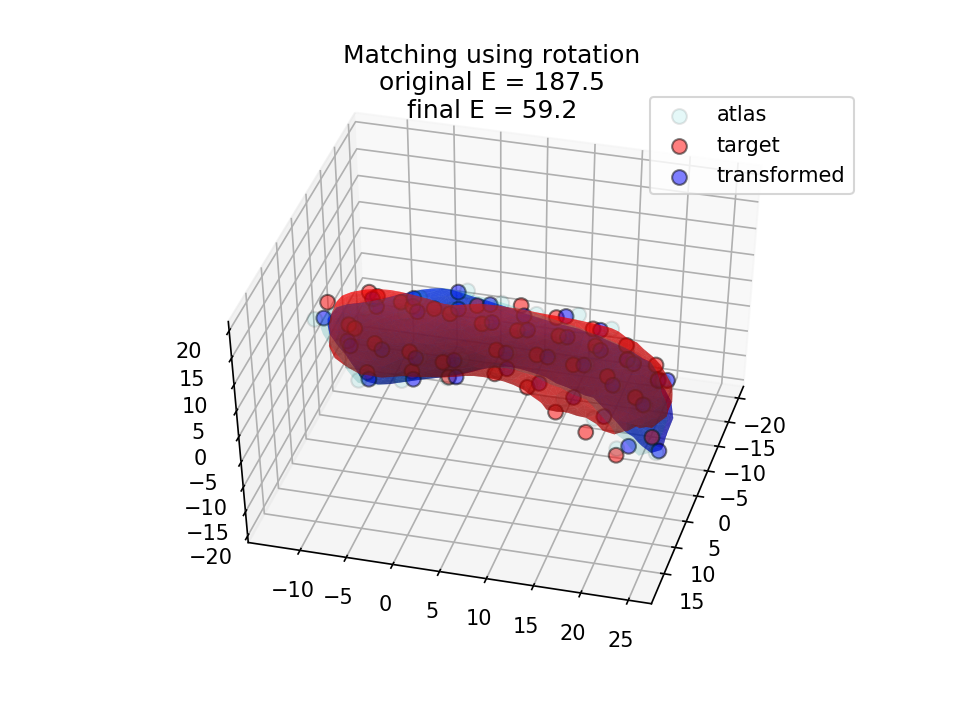

In [11]:
# Example: match X to Y using rotation
# compute cross covariance
xcov = Y.dot(X.transpose())
# compute its SVD, note that this returns the transpose of V
U,d,Vh = np.linalg.svd(xcov)
V = Vh.transpose()
D = np.diag(d)
A = U.dot(np.sign(D)).dot(V.transpose())
print('Estimated rotation matrix')
print(A)

# transform the data
AX = A.dot(X)
AV0 = A.dot(V0)

# calculate the cost before and after
Ebefore = np.sum((X-Y)**2*0.5)
Eafter = np.sum((AX-Y)**2*0.5)

f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.plot_trisurf(V0[0,:], V0[1,:], V0[2,:], triangles=F0, alpha=0.1, color='c')
h0 = ax.scatter(X[0,:], X[1,:], X[2,:], s=50, c='c', edgecolor='k', alpha=0.1)
ax.plot_trisurf(V1[0,:], V1[1,:], V1[2,:], triangles=F1, alpha=0.5, color='r')
hA0 = ax.scatter(Y[0,:], Y[1,:], Y[2,:], s=50, c='r', edgecolor='k', alpha=0.5)
ax.plot_trisurf(AV0[0,:], AV0[1,:], AV0[2,:], triangles=F0, alpha=0.5, color='b')
h1 = ax.scatter(AX[0,:], AX[1,:], AX[2,:], s=50, c='b', edgecolor='k', alpha=0.5)
ax.legend([h0,hA0,h1], ['atlas','target','transformed'])
ax.view_init(45, 15)
ss.axis_equal(ax)
ax.set_title('''Matching using rotation
original E = {:4.1f}
final E = {:4.1f}'''.format(Ebefore, Eafter))

# save the cost
Eall.append(Eafter)
Enames.append('Rotation')

## Comparison
Note that an affine alignment will always reduce the cost the most, becaues it includes all the others as special cases.  

However, for some applications its important to use other transformation models, such as rigid, or rigid with unifom scaling.

<IPython.core.display.Javascript object>


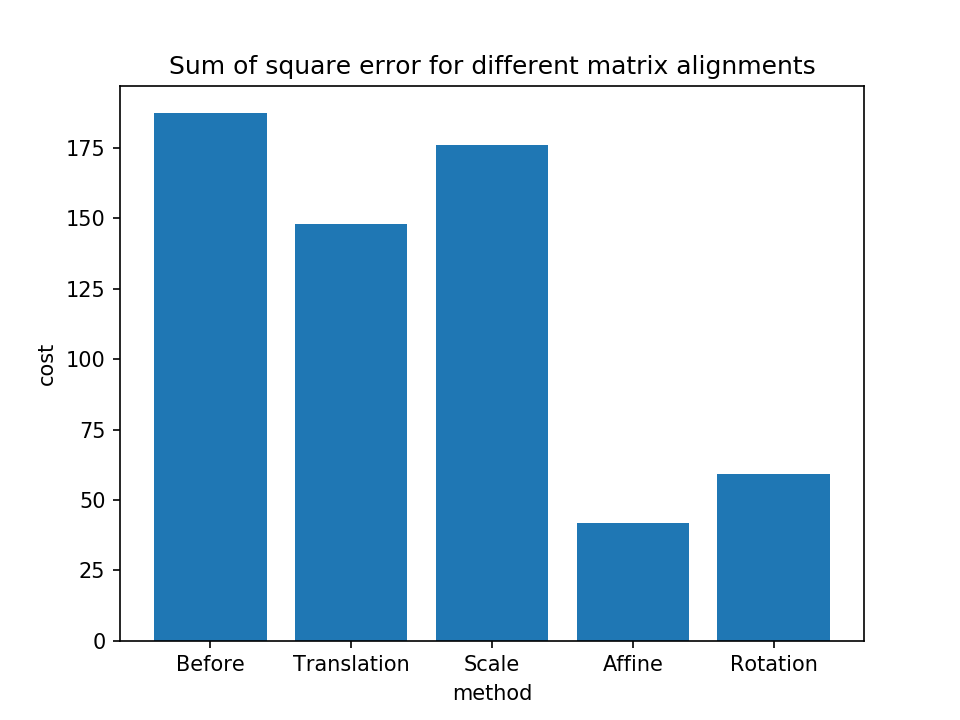

Text(0.5,1,'Sum of square error for different matrix alignments')

In [12]:
f,ax = plt.subplots()
ax.bar(Enames, Eall)
ax.set_xlabel('method')
ax.set_ylabel('cost')
plt.title('Sum of square error for different matrix alignments')